# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [25]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 2

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [26]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [27]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [39]:
epoch = 5
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 0.010
[2] loss: 0.013
[3] loss: 0.008
[4] loss: 0.007
[5] loss: 0.013


In [34]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 2])

In [40]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

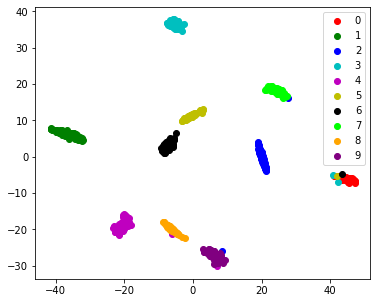

In [41]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

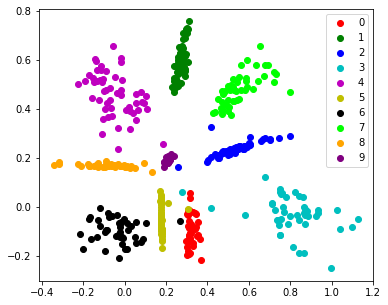

In [42]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

In [43]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [44]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [45]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[ 0.3189,  0.2799,  0.5271,  0.7930, -0.0422,  0.1766, -0.0672,  0.5453,
         -0.0445,  0.2119],
        [-0.0772,  0.6448,  0.2344,  0.0060,  0.5148, -0.0327, -0.0631,  0.5045,
          0.1665,  0.1952]])

In [46]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [47]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [48]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [49]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [50]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_7.cfg')

['./config/sswae_dev2_1_7.cfg']

In [51]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
#mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 2
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.393863e-01  D: 6.920407e-01  D2: 1.023345e-02  D3: 2.882844e-03
test loss: 1.883023e-01  D: 6.964777e-01  D2: -4.969788e-03  D3: 1.153204e-02


[default |INFO|model.py:1280] [02/80]  loss: 1.800422e-01  D: 6.924388e-01  D2: -4.313294e-03  D3: 9.012039e-03
test loss: 1.652639e-01  D: 6.880076e-01  D2: -5.424700e-03  D3: 7.410731e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.652043e-01  D: 6.946110e-01  D2: -4.326536e-03  D3: 1.091910e-02
test loss: 1.713810e-01  D: 6.529333e-01  D2: -3.392515e-03  D3: 1.279301e-02


[default |INFO|model.py:1280] [04/80]  loss: 1.522147e-01  D: 6.840958e-01  D2: -4.564716e-03  D3: 9.220444e-03
test loss: 1.539753e-01  D: 6.601566e-01  D2: -4.803028e-03  D3: 9.226844e-03


[default |INFO|model.py:1280] [05/80]  loss: 1.479616e-01  D: 6.956354e-01  D2: -4.430730e-03  D3: 1.207510e-02
test loss: 1.344471e-01  D: 6.745380e-01  D2: -4.767656e-03  D3: 1.618695e-02


[default |INFO|model.py:1280] [06/80]  loss: 1.297610e-01  D: 6.939195e-01  D2: -4.707734e-03  D3: 1.532236e-02
test loss: 1.216327e-01  D: 6.651834e-01  D2: -4.093447e-03  D3: 1.511856e-02


[default |INFO|model.py:1280] [07/80]  loss: 1.206799e-01  D: 6.939033e-01  D2: -4.287292e-03  D3: 1.453412e-02
test loss: 1.159705e-01  D: 6.757275e-01  D2: -5.726185e-03  D3: 1.548436e-02


[default |INFO|model.py:1280] [08/80]  loss: 1.164112e-01  D: 6.939881e-01  D2: -4.825568e-03  D3: 1.376143e-02
test loss: 1.145617e-01  D: 6.904665e-01  D2: -4.784126e-03  D3: 1.441233e-02


[default |INFO|model.py:1280] [09/80]  loss: 1.144637e-01  D: 6.935870e-01  D2: -4.945523e-03  D3: 1.264752e-02
test loss: 1.132878e-01  D: 6.939292e-01  D2: -5.136023e-03  D3: 1.275947e-02


[default |INFO|model.py:1280] [10/80]  loss: 1.129887e-01  D: 6.943730e-01  D2: -4.813573e-03  D3: 1.294475e-02
test loss: 1.105438e-01  D: 7.025317e-01  D2: -5.442877e-03  D3: 1.231380e-02


[default |INFO|model.py:1280] [11/80]  loss: 1.103207e-01  D: 6.932637e-01  D2: -5.067846e-03  D3: 1.314405e-02
test loss: 1.062888e-01  D: 7.125105e-01  D2: -5.628862e-03  D3: 1.194298e-02


[default |INFO|model.py:1280] [12/80]  loss: 1.077347e-01  D: 6.944400e-01  D2: -5.318867e-03  D3: 1.284984e-02
test loss: 1.038766e-01  D: 6.969597e-01  D2: -4.638805e-03  D3: 1.316194e-02


[default |INFO|model.py:1280] [13/80]  loss: 1.052916e-01  D: 6.931114e-01  D2: -5.458512e-03  D3: 1.264555e-02
test loss: 1.024813e-01  D: 6.788546e-01  D2: -5.880489e-03  D3: 1.184133e-02


[default |INFO|model.py:1280] [14/80]  loss: 1.044192e-01  D: 6.932096e-01  D2: -5.419935e-03  D3: 1.216122e-02
test loss: 1.021158e-01  D: 6.945386e-01  D2: -5.822105e-03  D3: 1.176306e-02


[default |INFO|model.py:1280] [15/80]  loss: 1.025514e-01  D: 6.933611e-01  D2: -5.521677e-03  D3: 1.222349e-02
test loss: 1.015244e-01  D: 6.967683e-01  D2: -4.010582e-03  D3: 1.390667e-02


[default |INFO|model.py:1280] [16/80]  loss: 1.010372e-01  D: 6.933355e-01  D2: -5.708324e-03  D3: 1.218905e-02
test loss: 9.836135e-02  D: 7.030281e-01  D2: -5.891228e-03  D3: 1.251412e-02


[default |INFO|model.py:1280] [17/80]  loss: 9.885112e-02  D: 6.935868e-01  D2: -6.018292e-03  D3: 1.209448e-02
test loss: 9.804473e-02  D: 6.938689e-01  D2: -5.486021e-03  D3: 1.254164e-02


[default |INFO|model.py:1280] [18/80]  loss: 9.743723e-02  D: 6.930843e-01  D2: -6.056336e-03  D3: 1.214432e-02
test loss: 9.752844e-02  D: 6.893162e-01  D2: -6.483507e-03  D3: 1.168497e-02


[default |INFO|model.py:1280] [19/80]  loss: 9.661624e-02  D: 6.934298e-01  D2: -6.063665e-03  D3: 1.217474e-02
test loss: 9.675106e-02  D: 6.996528e-01  D2: -6.883650e-03  D3: 1.204280e-02


[default |INFO|model.py:1280] [20/80]  loss: 9.592010e-02  D: 6.933929e-01  D2: -6.316878e-03  D3: 1.189295e-02
test loss: 9.649590e-02  D: 7.080298e-01  D2: -6.641216e-03  D3: 1.252126e-02


[default |INFO|model.py:1280] [21/80]  loss: 9.580522e-02  D: 6.932555e-01  D2: -6.299639e-03  D3: 1.168037e-02
test loss: 9.528727e-02  D: 6.962086e-01  D2: -6.172533e-03  D3: 1.213066e-02


[default |INFO|model.py:1280] [22/80]  loss: 9.458523e-02  D: 6.931857e-01  D2: -6.771318e-03  D3: 1.155708e-02
test loss: 9.643122e-02  D: 6.990147e-01  D2: -6.211119e-03  D3: 1.071522e-02


[default |INFO|model.py:1280] [23/80]  loss: 9.452342e-02  D: 6.935272e-01  D2: -6.609098e-03  D3: 1.152149e-02
test loss: 9.483516e-02  D: 6.874174e-01  D2: -6.895084e-03  D3: 1.174885e-02


[default |INFO|model.py:1280] [24/80]  loss: 9.384783e-02  D: 6.932721e-01  D2: -6.633372e-03  D3: 1.129003e-02
test loss: 9.259676e-02  D: 6.939564e-01  D2: -6.967974e-03  D3: 1.244206e-02


[default |INFO|model.py:1280] [25/80]  loss: 9.311249e-02  D: 6.932894e-01  D2: -7.015340e-03  D3: 1.136969e-02
test loss: 9.329363e-02  D: 6.972088e-01  D2: -7.181263e-03  D3: 1.287910e-02


[default |INFO|model.py:1280] [26/80]  loss: 9.254069e-02  D: 6.933421e-01  D2: -6.866501e-03  D3: 1.129839e-02
test loss: 9.430803e-02  D: 7.035063e-01  D2: -7.040110e-03  D3: 1.076646e-02


[default |INFO|model.py:1280] [27/80]  loss: 9.198566e-02  D: 6.934004e-01  D2: -7.004582e-03  D3: 1.110594e-02
test loss: 9.221733e-02  D: 6.940493e-01  D2: -7.360458e-03  D3: 1.092290e-02


[default |INFO|model.py:1280] [28/80]  loss: 9.190239e-02  D: 6.931412e-01  D2: -7.093029e-03  D3: 1.099210e-02
test loss: 9.332332e-02  D: 6.931079e-01  D2: -7.573738e-03  D3: 1.068208e-02


[default |INFO|model.py:1280] [29/80]  loss: 9.178486e-02  D: 6.937147e-01  D2: -7.113508e-03  D3: 1.096198e-02
test loss: 9.242353e-02  D: 6.920827e-01  D2: -7.305584e-03  D3: 1.236714e-02


[default |INFO|model.py:1280] [30/80]  loss: 9.120763e-02  D: 6.930528e-01  D2: -7.244231e-03  D3: 1.099566e-02
test loss: 9.166032e-02  D: 6.957390e-01  D2: -7.529287e-03  D3: 1.097272e-02


[default |INFO|model.py:1280] [31/80]  loss: 9.086986e-02  D: 6.931890e-01  D2: -7.420187e-03  D3: 1.092224e-02
test loss: 9.198049e-02  D: 6.953423e-01  D2: -6.680031e-03  D3: 1.078217e-02


[default |INFO|model.py:1280] [32/80]  loss: 9.030620e-02  D: 6.933397e-01  D2: -7.334102e-03  D3: 1.091210e-02
test loss: 9.186812e-02  D: 6.868211e-01  D2: -7.550402e-03  D3: 1.017336e-02


[default |INFO|model.py:1280] [33/80]  loss: 9.089609e-02  D: 6.934138e-01  D2: -7.359311e-03  D3: 1.059819e-02
test loss: 9.170552e-02  D: 6.907937e-01  D2: -7.464857e-03  D3: 1.061898e-02


[default |INFO|model.py:1280] [34/80]  loss: 9.040605e-02  D: 6.931939e-01  D2: -7.368113e-03  D3: 1.064971e-02
test loss: 9.059804e-02  D: 6.871472e-01  D2: -7.137327e-03  D3: 1.011677e-02


[default |INFO|model.py:1280] [35/80]  loss: 9.005328e-02  D: 6.934569e-01  D2: -7.605522e-03  D3: 1.077199e-02
test loss: 9.109940e-02  D: 6.933493e-01  D2: -7.510395e-03  D3: 1.024388e-02


[default |INFO|model.py:1280] [36/80]  loss: 8.984798e-02  D: 6.933101e-01  D2: -7.572171e-03  D3: 1.060614e-02
test loss: 9.213135e-02  D: 7.001802e-01  D2: -7.906027e-03  D3: 1.104214e-02


[default |INFO|model.py:1280] [37/80]  loss: 8.972141e-02  D: 6.933839e-01  D2: -7.621433e-03  D3: 1.056277e-02
test loss: 9.114605e-02  D: 6.850479e-01  D2: -7.355394e-03  D3: 8.971164e-03


[default |INFO|model.py:1280] [38/80]  loss: 8.894191e-02  D: 6.933042e-01  D2: -7.608150e-03  D3: 1.049623e-02
test loss: 8.928029e-02  D: 6.998316e-01  D2: -7.918110e-03  D3: 1.066049e-02


[default |INFO|model.py:1280] [39/80]  loss: 8.861085e-02  D: 6.932574e-01  D2: -7.811586e-03  D3: 1.046221e-02
test loss: 9.048118e-02  D: 6.969669e-01  D2: -6.985321e-03  D3: 9.941255e-03


[default |INFO|model.py:1280] [40/80]  loss: 8.815067e-02  D: 6.931934e-01  D2: -7.861579e-03  D3: 1.054036e-02
test loss: 9.001887e-02  D: 6.965696e-01  D2: -7.639084e-03  D3: 1.088425e-02


[default |INFO|model.py:1280] [41/80]  loss: 8.844268e-02  D: 6.933533e-01  D2: -7.859732e-03  D3: 1.036431e-02
test loss: 8.970012e-02  D: 6.911778e-01  D2: -8.030834e-03  D3: 1.163543e-02


[default |INFO|model.py:1280] [42/80]  loss: 8.812005e-02  D: 6.932193e-01  D2: -7.871512e-03  D3: 1.043859e-02
test loss: 8.973341e-02  D: 6.932697e-01  D2: -8.083563e-03  D3: 1.152157e-02


[default |INFO|model.py:1280] [43/80]  loss: 8.823583e-02  D: 6.934386e-01  D2: -7.979954e-03  D3: 1.033483e-02
test loss: 8.952885e-02  D: 6.944555e-01  D2: -7.984009e-03  D3: 1.035346e-02


[default |INFO|model.py:1280] [44/80]  loss: 8.818166e-02  D: 6.930969e-01  D2: -7.989370e-03  D3: 1.020073e-02
test loss: 8.826383e-02  D: 6.945107e-01  D2: -8.130093e-03  D3: 1.052957e-02


[default |INFO|model.py:1280] [45/80]  loss: 8.720860e-02  D: 6.934010e-01  D2: -8.061010e-03  D3: 1.027690e-02
test loss: 9.119491e-02  D: 6.942144e-01  D2: -7.231178e-03  D3: 1.125428e-02


[default |INFO|model.py:1280] [46/80]  loss: 8.705602e-02  D: 6.932084e-01  D2: -8.169530e-03  D3: 1.019684e-02
test loss: 8.756786e-02  D: 6.928952e-01  D2: -8.420429e-03  D3: 1.020434e-02


[default |INFO|model.py:1280] [47/80]  loss: 8.749535e-02  D: 6.933541e-01  D2: -8.078732e-03  D3: 1.010383e-02
test loss: 8.879034e-02  D: 6.941430e-01  D2: -8.368607e-03  D3: 1.096175e-02


[default |INFO|model.py:1280] [48/80]  loss: 8.707607e-02  D: 6.931114e-01  D2: -8.246469e-03  D3: 1.005985e-02
test loss: 8.776483e-02  D: 6.950633e-01  D2: -8.328152e-03  D3: 1.017167e-02


[default |INFO|model.py:1280] [49/80]  loss: 8.732600e-02  D: 6.934282e-01  D2: -8.231638e-03  D3: 1.000222e-02
test loss: 9.127181e-02  D: 6.952511e-01  D2: -7.846270e-03  D3: 9.734799e-03


[default |INFO|model.py:1280] [50/80]  loss: 8.661577e-02  D: 6.931269e-01  D2: -8.263526e-03  D3: 9.999573e-03
test loss: 8.907308e-02  D: 6.920968e-01  D2: -8.095293e-03  D3: 9.918864e-03


[default |INFO|model.py:1280] [51/80]  loss: 8.620442e-02  D: 6.932557e-01  D2: -8.327343e-03  D3: 1.004732e-02
test loss: 8.769100e-02  D: 6.921717e-01  D2: -8.220854e-03  D3: 9.066674e-03


[default |INFO|model.py:1280] [52/80]  loss: 8.669095e-02  D: 6.932434e-01  D2: -8.222634e-03  D3: 1.000042e-02
test loss: 8.659182e-02  D: 6.903199e-01  D2: -8.632975e-03  D3: 1.002535e-02


[default |INFO|model.py:1280] [53/80]  loss: 8.623063e-02  D: 6.933160e-01  D2: -8.369721e-03  D3: 9.949211e-03
test loss: 8.774254e-02  D: 6.949211e-01  D2: -8.494997e-03  D3: 9.442786e-03


[default |INFO|model.py:1280] [54/80]  loss: 8.604556e-02  D: 6.932106e-01  D2: -8.413145e-03  D3: 9.970964e-03
test loss: 8.829572e-02  D: 6.940226e-01  D2: -8.570652e-03  D3: 1.018078e-02


[default |INFO|model.py:1280] [55/80]  loss: 8.543489e-02  D: 6.932054e-01  D2: -8.410923e-03  D3: 9.807318e-03
test loss: 8.659315e-02  D: 6.877755e-01  D2: -8.487005e-03  D3: 9.565062e-03


[default |INFO|model.py:1280] [56/80]  loss: 8.523224e-02  D: 6.933406e-01  D2: -8.437732e-03  D3: 9.822343e-03
test loss: 8.813580e-02  D: 6.952724e-01  D2: -8.325090e-03  D3: 9.349446e-03


[default |INFO|model.py:1280] [57/80]  loss: 8.515770e-02  D: 6.932749e-01  D2: -8.509445e-03  D3: 9.788820e-03
test loss: 8.825231e-02  D: 6.911079e-01  D2: -8.040695e-03  D3: 9.718892e-03


[default |INFO|model.py:1280] [58/80]  loss: 8.510346e-02  D: 6.932158e-01  D2: -8.520103e-03  D3: 9.789309e-03
test loss: 8.799890e-02  D: 6.920410e-01  D2: -8.181257e-03  D3: 9.032491e-03


[default |INFO|model.py:1280] [59/80]  loss: 8.491826e-02  D: 6.932040e-01  D2: -8.510199e-03  D3: 9.788068e-03
test loss: 8.856990e-02  D: 6.923217e-01  D2: -8.008184e-03  D3: 8.689698e-03


[default |INFO|model.py:1280] [60/80]  loss: 8.523903e-02  D: 6.932464e-01  D2: -8.495407e-03  D3: 9.694274e-03
test loss: 8.752619e-02  D: 6.971378e-01  D2: -8.215036e-03  D3: 9.619166e-03


[default |INFO|model.py:1280] [61/80]  loss: 8.520207e-02  D: 6.933593e-01  D2: -8.517690e-03  D3: 9.668531e-03
test loss: 8.731758e-02  D: 6.881540e-01  D2: -7.907038e-03  D3: 9.306267e-03


[default |INFO|model.py:1280] [62/80]  loss: 8.452015e-02  D: 6.932819e-01  D2: -8.555908e-03  D3: 9.698813e-03
test loss: 8.647720e-02  D: 6.922465e-01  D2: -8.360043e-03  D3: 9.877212e-03


[default |INFO|model.py:1280] [63/80]  loss: 8.461510e-02  D: 6.932671e-01  D2: -8.626644e-03  D3: 9.630447e-03
test loss: 8.748696e-02  D: 6.937651e-01  D2: -8.467445e-03  D3: 9.024582e-03


[default |INFO|model.py:1280] [64/80]  loss: 8.425194e-02  D: 6.932016e-01  D2: -8.564043e-03  D3: 9.669388e-03
test loss: 8.701268e-02  D: 6.921811e-01  D2: -8.819265e-03  D3: 9.454730e-03


[default |INFO|model.py:1280] [65/80]  loss: 8.426495e-02  D: 6.932587e-01  D2: -8.583199e-03  D3: 9.534345e-03
test loss: 8.750863e-02  D: 6.941494e-01  D2: -8.581562e-03  D3: 9.801080e-03


[default |INFO|model.py:1280] [66/80]  loss: 8.403291e-02  D: 6.932167e-01  D2: -8.597716e-03  D3: 9.532548e-03
test loss: 8.677910e-02  D: 6.927487e-01  D2: -8.707724e-03  D3: 9.026349e-03


[default |INFO|model.py:1280] [67/80]  loss: 8.406470e-02  D: 6.931804e-01  D2: -8.669879e-03  D3: 9.556155e-03
test loss: 8.626562e-02  D: 6.904438e-01  D2: -8.573856e-03  D3: 9.703748e-03


[default |INFO|model.py:1280] [68/80]  loss: 8.394453e-02  D: 6.932945e-01  D2: -8.651940e-03  D3: 9.555658e-03
test loss: 8.552800e-02  D: 6.948115e-01  D2: -8.666706e-03  D3: 9.791570e-03


[default |INFO|model.py:1280] [69/80]  loss: 8.396953e-02  D: 6.932636e-01  D2: -8.682558e-03  D3: 9.538561e-03
test loss: 8.690386e-02  D: 6.934330e-01  D2: -8.598499e-03  D3: 8.725194e-03


[default |INFO|model.py:1280] [70/80]  loss: 8.317508e-02  D: 6.932101e-01  D2: -8.745723e-03  D3: 9.486485e-03
test loss: 8.718780e-02  D: 6.967484e-01  D2: -8.406668e-03  D3: 9.824684e-03


[default |INFO|model.py:1280] [71/80]  loss: 8.386063e-02  D: 6.932623e-01  D2: -8.642015e-03  D3: 9.477105e-03
test loss: 8.613635e-02  D: 6.969325e-01  D2: -8.637142e-03  D3: 9.383850e-03


[default |INFO|model.py:1280] [72/80]  loss: 8.338777e-02  D: 6.932216e-01  D2: -8.715733e-03  D3: 9.497068e-03
test loss: 8.563672e-02  D: 6.927528e-01  D2: -8.576508e-03  D3: 1.003319e-02


[default |INFO|model.py:1280] [73/80]  loss: 8.407579e-02  D: 6.932703e-01  D2: -8.723877e-03  D3: 9.417646e-03
test loss: 8.569728e-02  D: 6.920772e-01  D2: -8.818998e-03  D3: 9.513012e-03


[default |INFO|model.py:1280] [74/80]  loss: 8.323443e-02  D: 6.932214e-01  D2: -8.663530e-03  D3: 9.437446e-03
test loss: 8.454572e-02  D: 6.933319e-01  D2: -8.895540e-03  D3: 9.302972e-03


[default |INFO|model.py:1280] [75/80]  loss: 8.290440e-02  D: 6.932583e-01  D2: -8.716547e-03  D3: 9.377763e-03
test loss: 8.569326e-02  D: 6.942256e-01  D2: -8.968639e-03  D3: 9.849650e-03


[default |INFO|model.py:1280] [76/80]  loss: 8.298395e-02  D: 6.932549e-01  D2: -8.745715e-03  D3: 9.381183e-03
test loss: 8.577207e-02  D: 6.934623e-01  D2: -8.523178e-03  D3: 9.185877e-03


[default |INFO|model.py:1280] [77/80]  loss: 8.269456e-02  D: 6.931415e-01  D2: -8.728806e-03  D3: 9.374200e-03
test loss: 8.747647e-02  D: 6.926965e-01  D2: -8.893042e-03  D3: 9.082047e-03


[default |INFO|model.py:1280] [78/80]  loss: 8.326315e-02  D: 6.933271e-01  D2: -8.744947e-03  D3: 9.370259e-03
test loss: 8.634371e-02  D: 6.902616e-01  D2: -8.299885e-03  D3: 9.023392e-03


[default |INFO|model.py:1280] [79/80]  loss: 8.259612e-02  D: 6.931817e-01  D2: -8.772613e-03  D3: 9.412968e-03
test loss: 8.507711e-02  D: 6.947109e-01  D2: -8.635101e-03  D3: 9.808661e-03


[default |INFO|model.py:1280] [80/80]  loss: 8.276413e-02  D: 6.932784e-01  D2: -8.786217e-03  D3: 9.329935e-03
test loss: 8.566937e-02  D: 6.939929e-01  D2: -8.686247e-03  D3: 9.292062e-03


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3115.429s


# Test

In [52]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [53]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [54]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

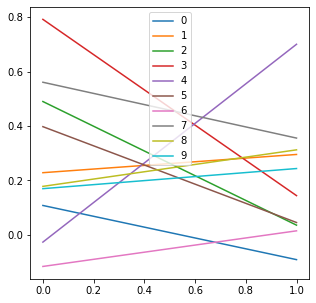

In [55]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

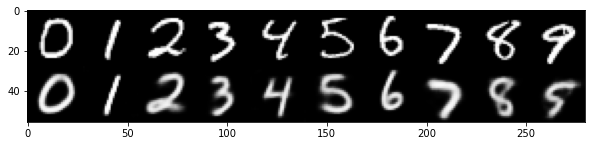

In [56]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [57]:
from XAE.sampler import gaus

exn = 5

In [58]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

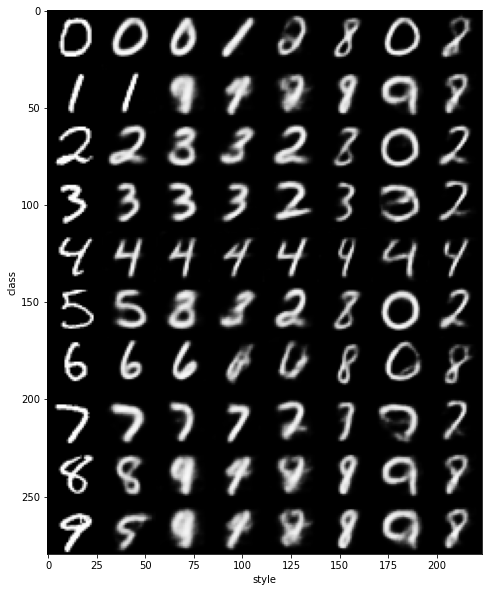

In [59]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [60]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

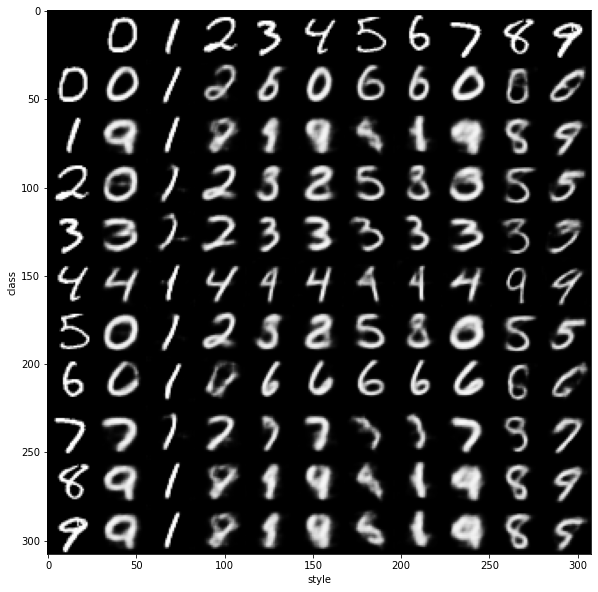

In [61]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()